In [14]:
from scipy.io import loadmat
import pandas as pd
import os
import matplotlib
matplotlib.use("Agg")  # Must be before importing any matplotlib.pyplot-dependent code
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from mapd import Trial, Table
import h5py
import skvideo.io
from scipy.stats import mode

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
T = Table('LEDFlashTriggerPiezoControl_250304_F3_C1_Table.parquet') # LEDFlashTriggerPiezoControl_Raw_241205_F2_C1_243
# tl = T.trial_list

block_1 = T.df.loc[T.df['op_cnd_blocks'] == 1]

T = pd.read_parquet("D:\\Data\\250304\\250304_F3_C1\\LEDFlashTriggerPiezoControl_250304_F3_C1_Table.parquet")
Getting trials


Pandas Apply:   0%|          | 0/1450 [00:00<?, ?it/s]

In [ ]:
tr = block_1.loc[1,'Trial']
# tr.plot_probe_groups()
# tr.probe_position

array([[522.99728394],
       [522.99728394],
       [522.99728394],
       ...,
       [545.17936707],
       [545.17936707],
       [545.17936707]])

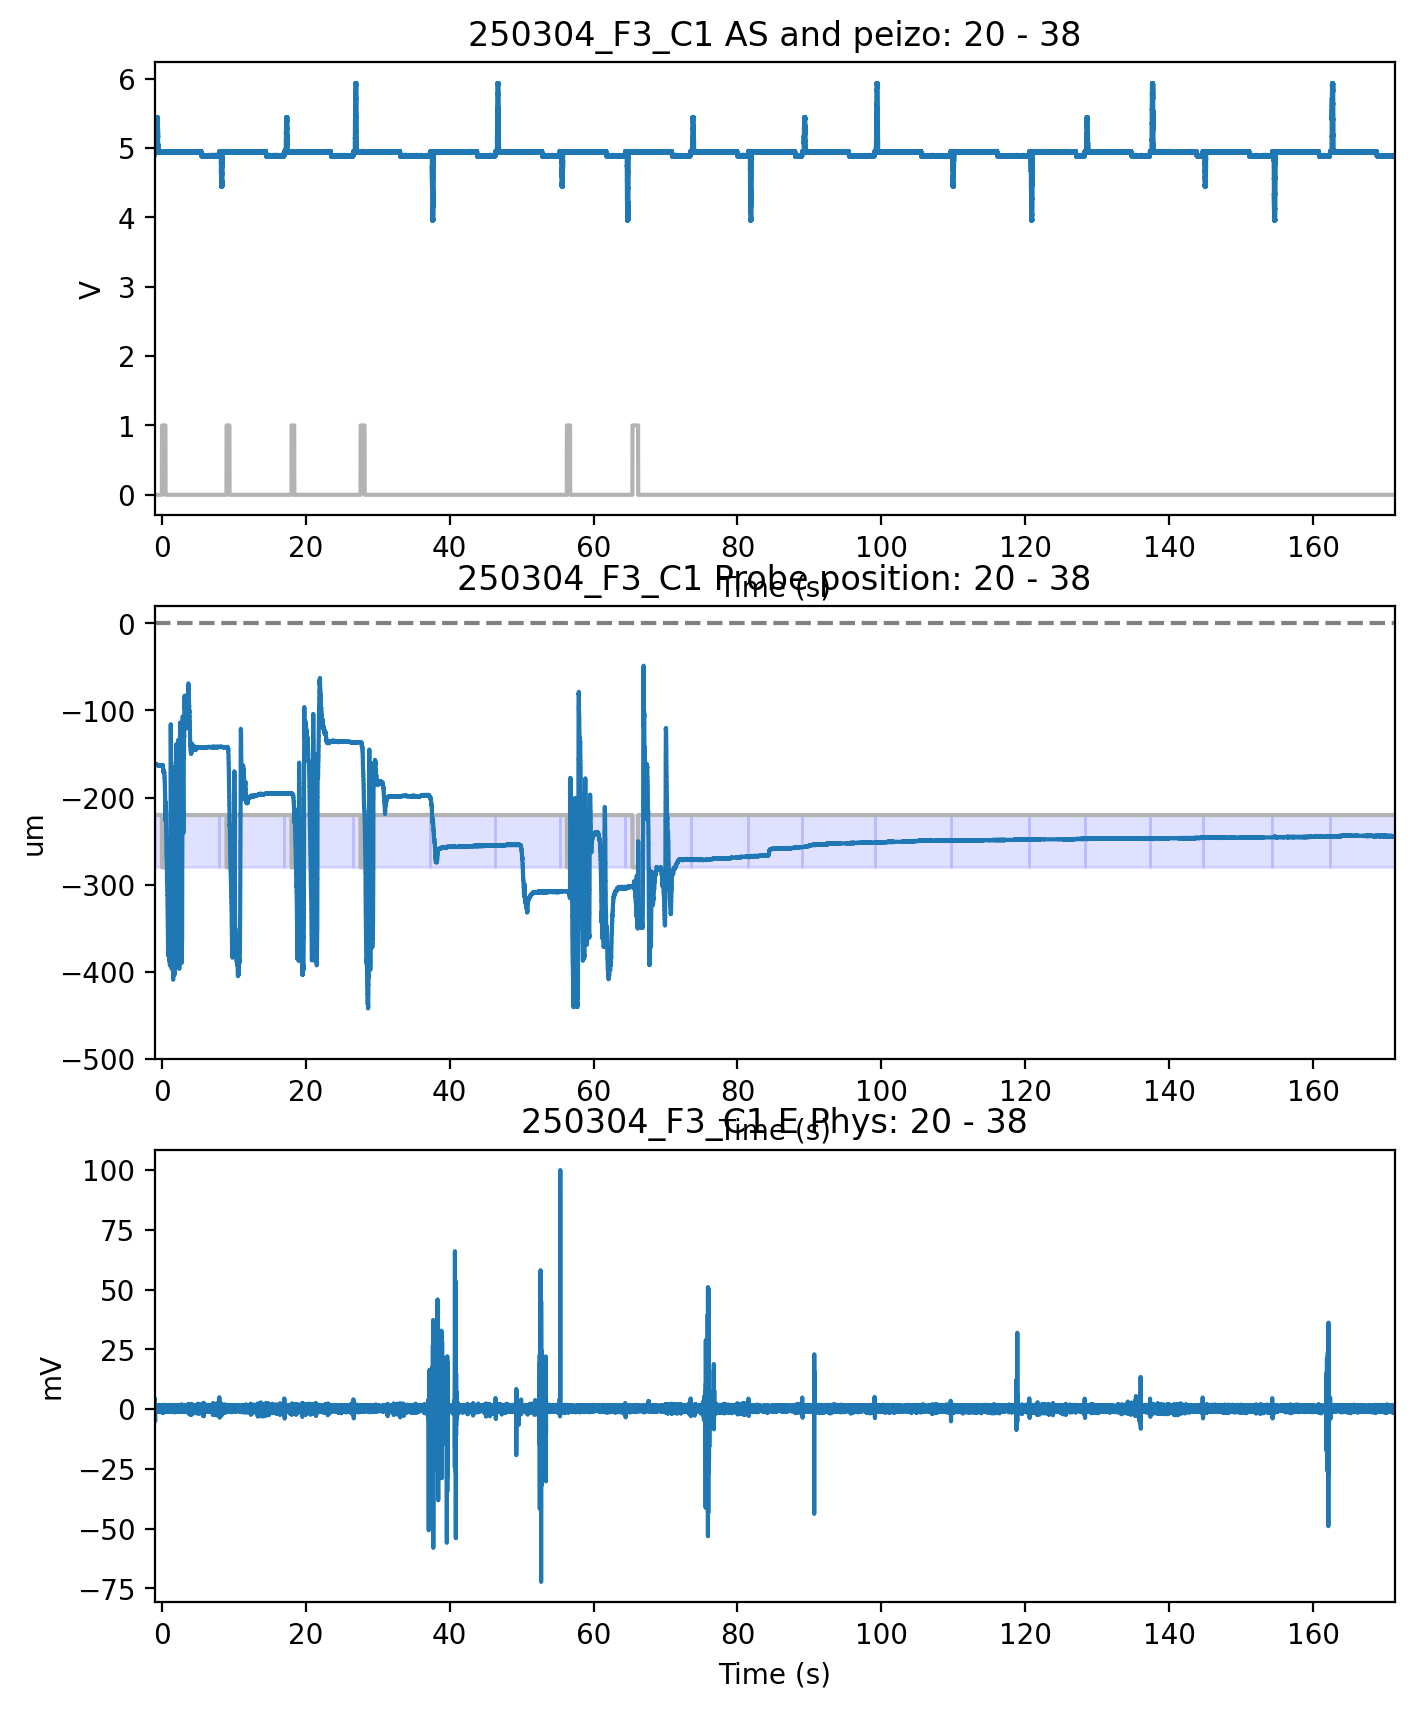

In [13]:
idx = T.df.loc[20:38].index
%matplotlib inline
fig,ax = T.plot_some_trials(index=idx, from_zero=True)
fig.canvas.draw()
fig

In [6]:
fig = T.plot_probe_position_heatmap()

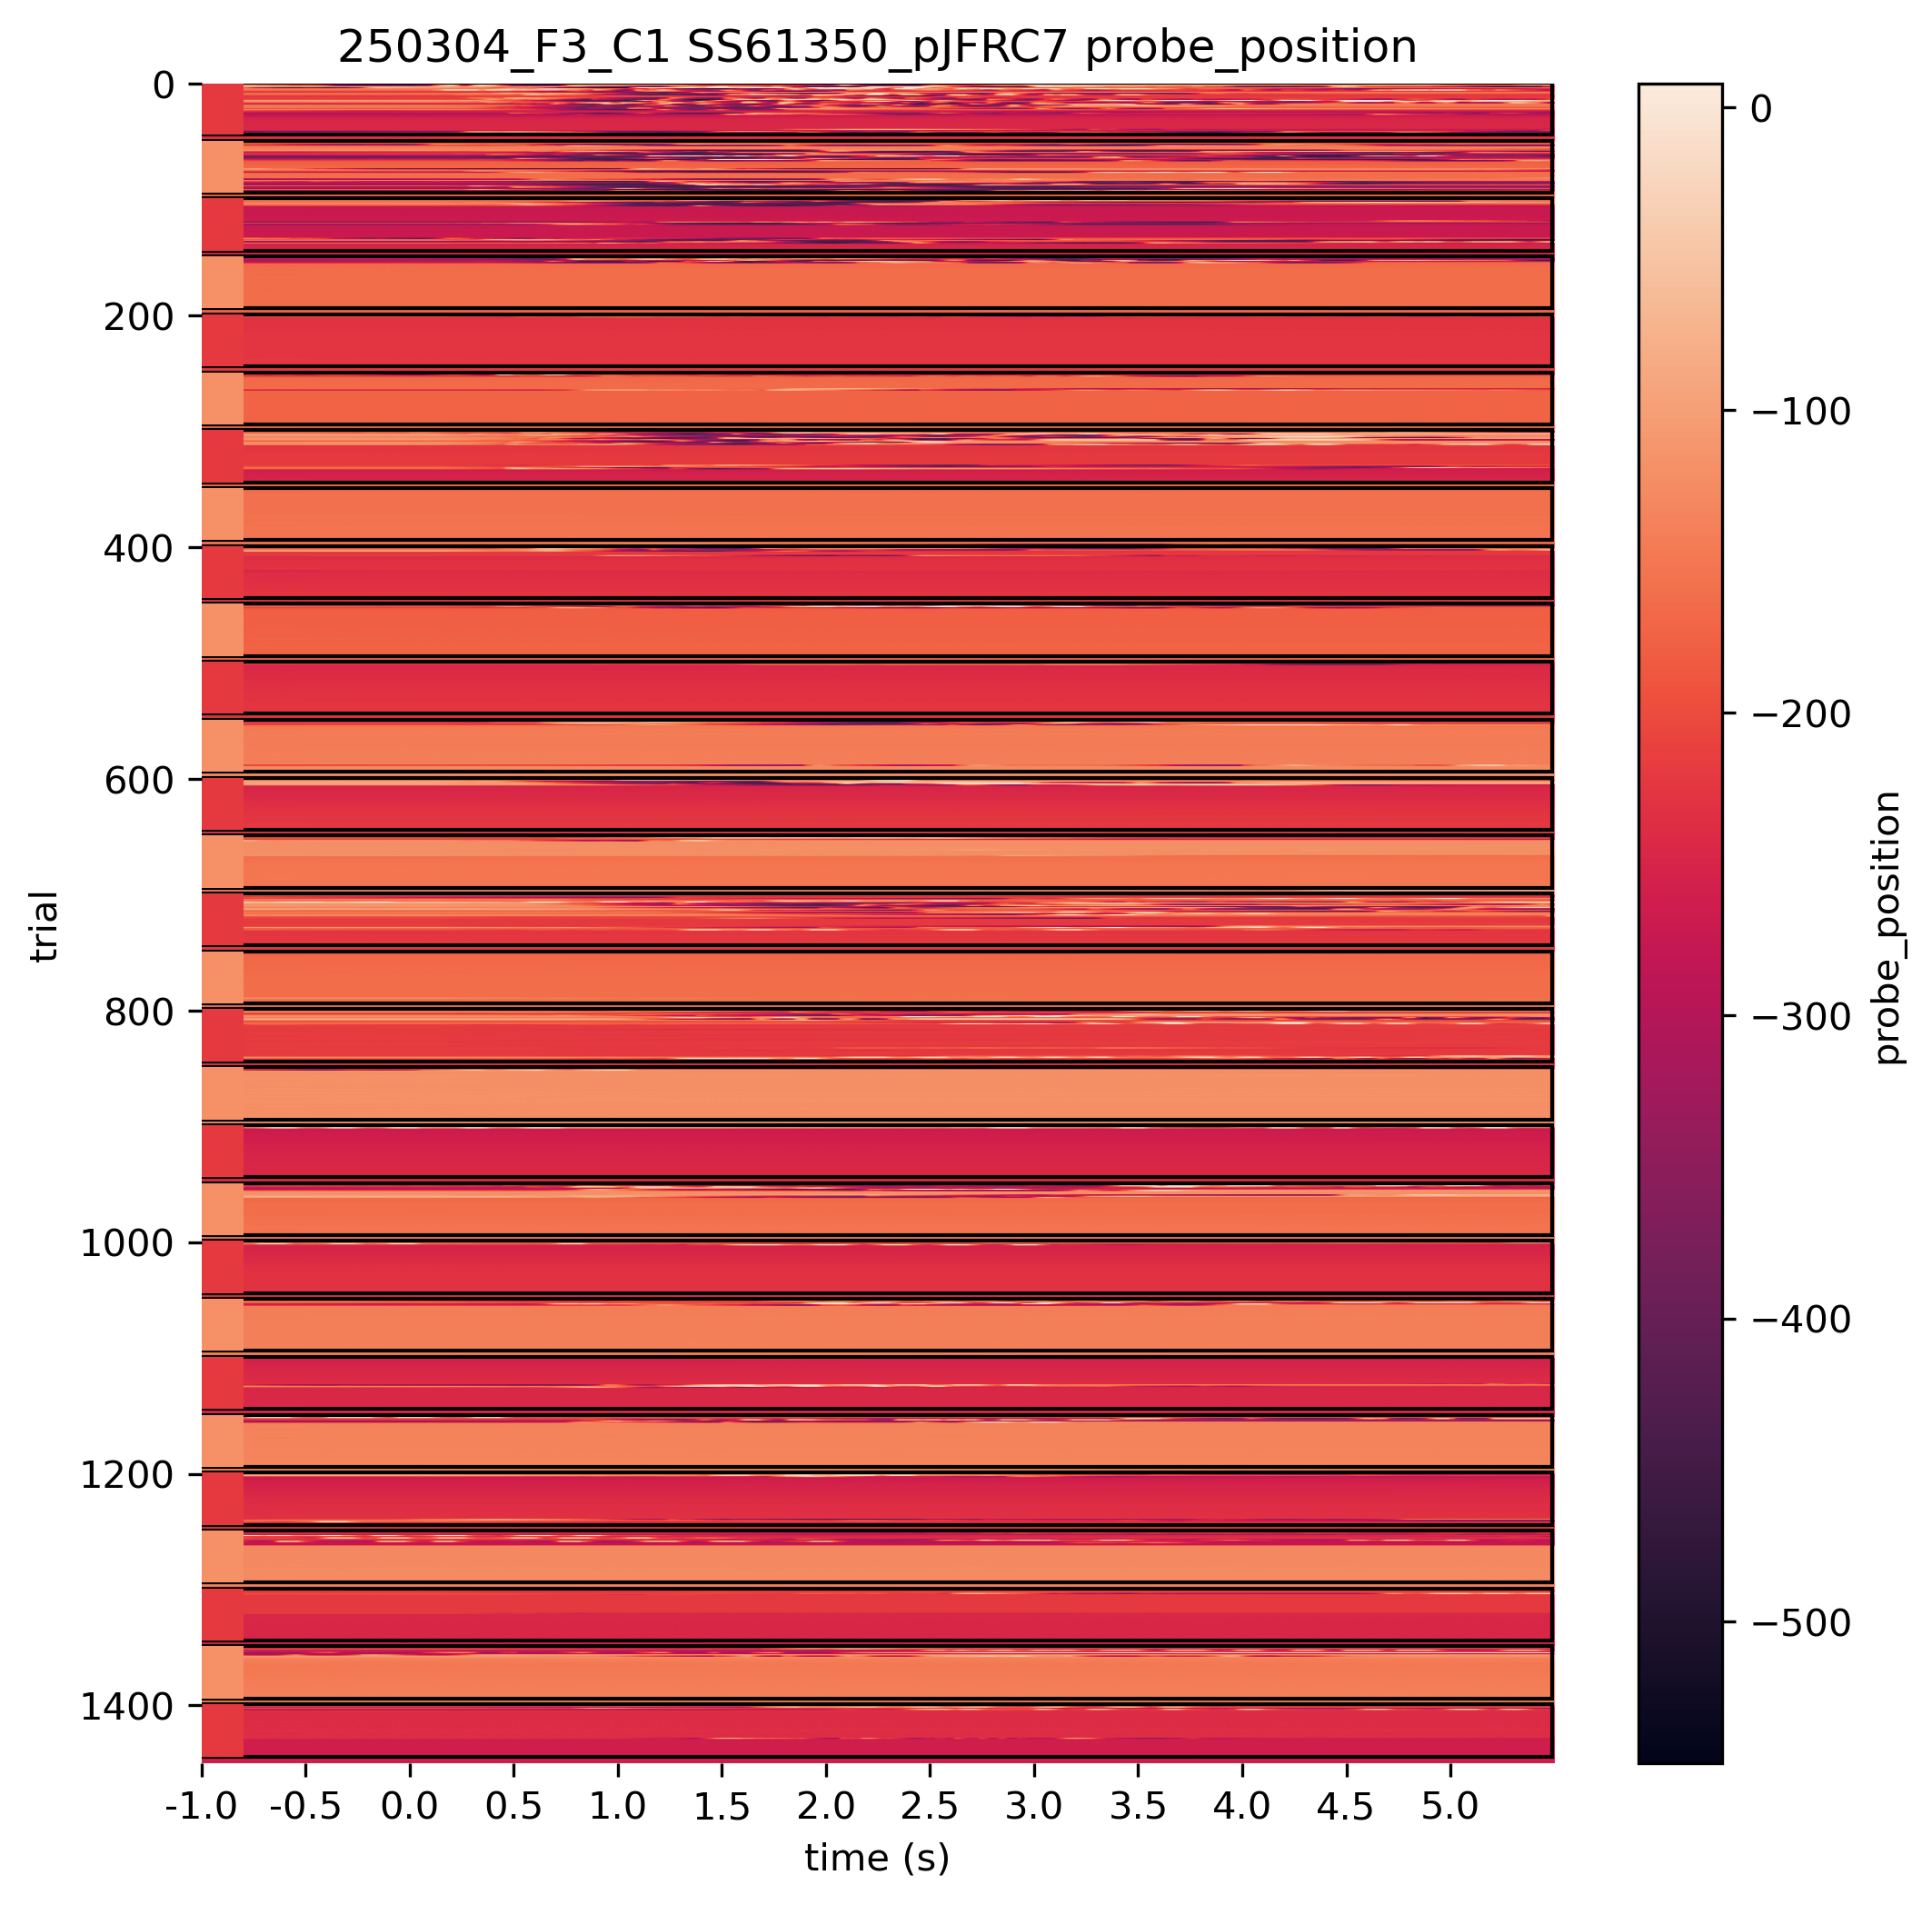

In [10]:
fig[0].canvas.draw()
fig[0]

In [ ]:
T.make_movie_from_index(index=idx)

In [24]:
def create_probe_frame(xlim=(0, 1280), ylim=(0, 128), radius=8):
    fig, ax = plt.subplots(figsize=(6.4, 0.64), dpi=200)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    assert fig.canvas.get_width_height() == (1280, 128), "Unexpected canvas size"
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    ax.axis('off')

    # Placeholder target rectangle (initial position = 0, width = 0)
    rect = patches.Rectangle((0, 0), 0, ylim[1], edgecolor='white', facecolor='none')
    ax.add_patch(rect)

    # Placeholder probe dot
    dot = patches.Circle((0, ylim[1] // 2), radius, color='white')
    ax.add_patch(dot)



    time_text = ax.text(
        0.98, 0.02, "", transform=ax.transAxes,
        color='white', fontsize=10, ha='right', va='bottom'
    )

    return fig, ax, dot, rect, time_text


def init_video_writer(filename, frame_rate=30, crf=28):
    writer = skvideo.io.FFmpegWriter(
        filename,
        inputdict={'-framerate': str(frame_rate)},
        outputdict={
            '-vcodec': 'libx264',
            '-pix_fmt': 'yuv420p',
            '-crf': str(crf),
            '-preset': 'slow',
            '-movflags': '+faststart'
        }
    )
    return writer

def update_probe_frame(dot, rect, probe_position, target_x, target_width, 
                       time_text=None, time_seconds = None, light_on=False, 
                       edgewidth_inside=3, edgewidth_outside=1):
    """
    Updates the dot and rectangle in the frame.
    - dot: matplotlib Circle object
    - rect: matplotlib Rectangle object
    - probe_position: scalar or (x, y)
    - target_x: left edge of target region
    - target_width: width of target region
    - light_on: bool, adds yellow fill to rectangle if True
    - edgewidth_inside: line width if probe is inside the target
    - edgewidth_outside: line width if probe is outside the target
    """

    # Update dot position
    if np.ndim(probe_position) == 0 or len(probe_position) == 1:
        x = probe_position[0] if np.ndim(probe_position) else probe_position
        y = dot.center[1]
    else:
        x, y = probe_position[0], probe_position[1]
    dot.center = (x, y)

    # Update target rectangle
    rect.set_x(target_x)
    rect.set_width(target_width)
    rect.set_edgecolor('blue' if light_on else 'white')

    inside = target_x <= x <= (target_x + target_width)
    rect.set_linewidth(edgewidth_inside if inside else edgewidth_outside)

    # Update time text
    if time_text is not None and time_seconds is not None:
        time_text.set_text(f"{time_seconds:.2f} s")

In [25]:
# Setup
fig, ax, dot, rect,time_text = create_probe_frame(radius=6)
# writer = init_video_writer("debug_probe_video.mp4", frame_rate=30)


tr_probe_position = tr.probe_position[tr.downsample_probe]
tr_ardo = tr.arduino_output[tr.downsample_probe].astype(np.bool)
tr_time = tr.time[tr.downsample_probe]

fr = 1/mode(np.diff(tr.time[tr.downsample_probe])).mode
# writer = init_video_writer("debug_probe_video.mp4", frame_rate=fr, crf=28)


update_probe_frame(
        dot, rect,
        probe_position=tr_probe_position[0],
        target_x=tr.params['pyasXPosition'],
        target_width=tr.params['pyasWidth'],
        light_on=tr_ardo[0]
    )

In [35]:
T.genotype

'SS61350_pJFRC7'

In [ ]:
writer = init_video_writer(f"./probe_movies/pm_{T.day}_F{T.fly}_C{T.cell}_{T.genotype}.mp4", frame_rate=fr, crf=28)

fig.canvas.draw()

# Example loop
for idx,pos,ao,tstep in zip(range(len(tr_probe_position)),tr_probe_position,tr_ardo,tr_time):
    # idx = 500
    # pos = tr_probe_position[idx]
    # ao = tr_ardo[idx]
    # tstep = tr_time[idx]
    # if idx == 500:   
    update_probe_frame(
        dot, rect,
        probe_position=pos,
        target_x=tr.params['pyasXPosition'],
        target_width=tr.params['pyasWidth'],
        time_text=time_text,
        time_seconds=tstep,
        light_on=ao
    )

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = np.asarray(fig.canvas.buffer_rgba())
    image_rgb = image[..., :3]  # drop alpha for ffmpeg compatibility
    writer.writeFrame(image_rgb)

writer.close()
plt.close(fig)

C:\Users\tony\AppData\Local\Temp\ipykernel_21412\4173025519.py:23: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.64] inches
200 dpi
(1280, 128) pixels
(128, 1280, 4)
[6.4  0.6

In [ ]:


def make_probe_position_video(tr, output_path="probe_video.mp4", frame_rate=30, radius=8):
    """
    Generate a video of probe position over time.

    Parameters:
    - tr: Trial object with attributes `params` and `probe_position`
    - output_path: str, path to output .mp4 file
    - frame_rate: int, frames per second
    - radius: int, radius of the probe dot in data units
    """

    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(6.4, 0.64), dpi=200)
    ax.set_xlim(0, 1280)
    ax.set_ylim(0, 128)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    ax.axis('off')

    # Static rectangle (outline of pyas)
    rect = patches.Rectangle(
        (tr.params['pyasXPosition'], 0),
        tr.params['pyasWidth'], 128,
        edgecolor='white', facecolor='none'
    )
    ax.add_patch(rect)

    # Dynamic dot (initialize once)
    y_default = 64  # middle of the range if position is 1D
    first_pos = tr.probe_position[0]
    if np.ndim(first_pos) == 0 or len(first_pos) == 1:
        dot = patches.Circle((first_pos[0] if np.ndim(first_pos) else first_pos, y_default), radius, color='white')
    else:
        dot = patches.Circle((first_pos[0], first_pos[1]), radius, color='white')
    ax.add_patch(dot)

    # Set up writer
    writer = skvideo.io.FFmpegWriter(
        output_path,
        inputdict={'-framerate': str(frame_rate)},
        outputdict={
            '-vcodec': 'libx264',
            '-pix_fmt': 'yuv420p',
            '-crf': '28',
            '-preset': 'slow',
            '-movflags': '+faststart'
        }
    )

    # Generate frames
    for pos in tr.probe_position:
        # Update dot position
        if np.ndim(pos) == 0 or len(pos) == 1:
            x, y = pos[0] if np.ndim(pos) else pos, y_default
        else:
            x, y = pos[0], pos[1]
        dot.center = (x, y)

        # Render and write frame
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        writer.writeFrame(image)

    writer.close()
    plt.close(fig)
    print(f"Video saved to {output_path}")

In [ ]:
import numpy as np

def make_probe_movie(self,index = None):
    """
    Make a movie of the probe data.
    """

    if index is None:
        index = self.df.index
    elif not isinstance(index, pd.Series):
        if isinstance(index, (list, np.ndarray)):
            index = pd.Series(index)
        else:
            raise TypeError("Index must be a pandas Series or a list/array-like object.")
    else:
        pass  # index is already a Series

    # Get the probe data
    tabl = self.df.loc[index]

    # setup the figure
    fig, ax = plt.subplots()
    fig.set_size_inches(12.8, 1.28)  # Set the figure size as needed


In [ ]:
T.df.op_cnd_blocks.value_counts()

In [ ]:
T_ = T.df[~T.df['is_rest']]

In [ ]:
for ocb in T_.op_cnd_blocks.unique():
            T_rows = T_[T_.op_cnd_blocks==ocb]

In [ ]:
a = 'hi' if T_rows.pyasState.unique()=='hi' else 'lo'
a

In [ ]:
T.plot_outcomes(savefig=True)

In [ ]:
plt.close()

In [ ]:
for ocb in T_.op_cnd_blocks.unique():
    T_rows = T_[T_.op_cnd_blocks==ocb]
    tr_max = T_rows.index.max()
    tr_min = T_rows.index.min()
    print(f'[{tr_min}, {tr_max}]')

In [ ]:
T_rows = T